# 

In [5]:
import os
import random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
# GPU 설정
gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

NameError: name 'tf' is not defined

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import kerastuner as kt
import tensorflow as tf

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:
tuner = kt.Hyperband(
    build_tuned_model,
    objective="val_accuracy",
    max_epochs=15,
    factor=3,
    directory="tuner_dir",
    project_name="09_03_resnet_tuning",
)

# 3) 조기종료 콜백
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)


In [ ]:
def build_tuned_model(hp):
    # 1) Base model
    base = ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    base.trainable = False

    # 2) 헤드(head) 부분에 하이퍼파라미터 연결
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # dropout 비율 튜닝
    drop_rate = hp.Float("dropout", 0.2, 0.6, step=0.1)
    x = Dropout(drop_rate)(x)

    # Dense 유닛 수 튜닝
    units = hp.Int("dense_units", 16, 128, step=16)
    reg = hp.Choice("l2_reg", [1e-4, 1e-3, 1e-2])
    x = Dense(units, activation="relu", kernel_regularizer=l2(reg))(x)
    x = Dropout(drop_rate)(x)

    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)

    # 학습률 튜닝
    lr = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [4]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.7, 1.3],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = ResNet50V2(include_top=False, weights="imagenet", input_shape=input_shape)
base_model.trainable = False

inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss="binary_crossentropy",
              metrics=["accuracy"])

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [5]:
# Dropout 증가 + L2 + Dense 노드 축소
# model=Sequential([
#     Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
#     BatchNormalization(),
#     MaxPooling2D(2),

#     Conv2D(96, 3, activation="relu"),
#     BatchNormalization(),
#     MaxPooling2D(2),

#     Flatten(),
#     Dense(32, activation="relu", kernel_regularizer=l2(0.001)),  # Dense 노드 축소 + 정규화
#     Dropout(0.4),  # Dropout 증가
#     Dense(1, activation="sigmoid")
# ])

# model.compile(optimizer=Adam(learning_rate=0.0005),
#             loss="binary_crossentropy", metrics=["accuracy"])

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

In [7]:
history=model.fit(train_generator, validation_data=val_generator,
                epochs=20, callbacks=[early_stop], verbose=1)

Epoch 1/20
1200/1200 [==============================] - 76s 60ms/step - loss: 0.2789 - accuracy: 0.9042 - val_loss: 0.2208 - val_accuracy: 0.9197
Epoch 2/20
1200/1200 [==============================] - 72s 60ms/step - loss: 0.1911 - accuracy: 0.9420 - val_loss: 0.1845 - val_accuracy: 0.9378
Epoch 3/20
1200/1200 [==============================] - 68s 57ms/step - loss: 0.1763 - accuracy: 0.9454 - val_loss: 0.2404 - val_accuracy: 0.9101
Epoch 4/20
1200/1200 [==============================] - 69s 57ms/step - loss: 0.1735 - accuracy: 0.9462 - val_loss: 0.2021 - val_accuracy: 0.9302
Epoch 5/20
Restoring model weights from the end of the best epoch: 2.s: 0.1689 - accuracy: 0.9492  
1200/1200 [==============================] - 68s 56ms/step - loss: 0.1688 - accuracy: 0.9492 - val_loss: 0.2029 - val_accuracy: 0.9294
Epoch 5: early stopping


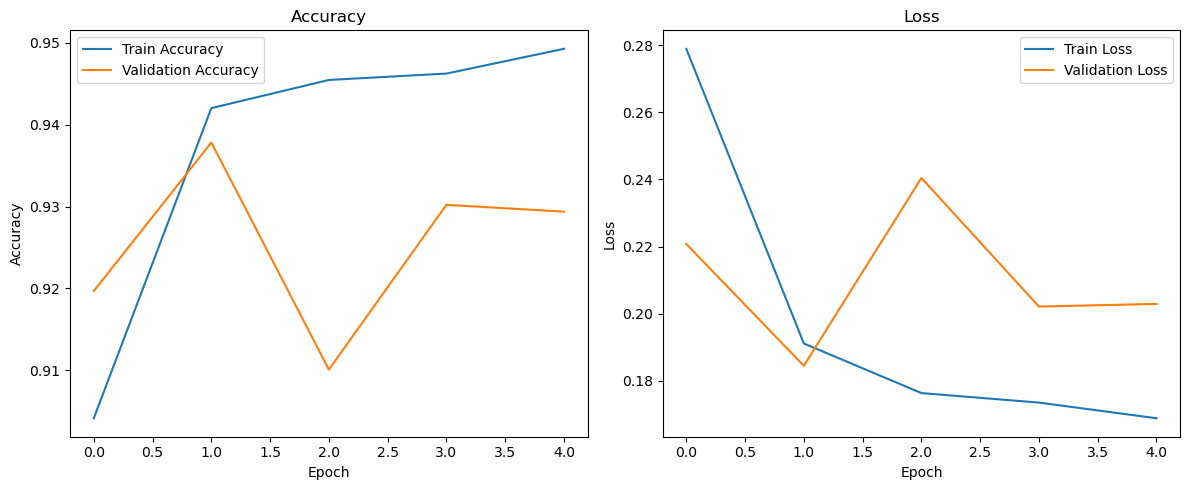

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/02_readjusted_training_plot.png")
plt.show()

              precision    recall  f1-score   support

      closed       0.91      0.97      0.94      4800
        open       0.97      0.90      0.93      4800

    accuracy                           0.93      9600
   macro avg       0.94      0.93      0.93      9600
weighted avg       0.94      0.93      0.93      9600



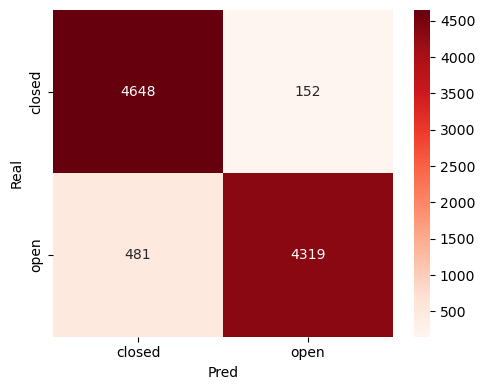

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

# classification report
report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)
with open("../../results/reports/03_resnet_classification_report.txt", "w") as f:
    f.write(report)

# confusion matrix
conf_matirx=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matirx, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/03_resnet_confusion_matrix.png")
plt.show()

In [11]:
os.makedirs("../../src/models/09_03ResNet_Model", exist_ok=True)
model.save("../../src/models/09_03ResNet_Model/readjusted_model.keras")